<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Permanent-Income-Model" data-toc-modified-id="Permanent-Income-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Permanent Income Model</a></span><ul class="toc-item"><li><span><a href="#GCN-File" data-toc-modified-id="GCN-File-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>GCN File</a></span><ul class="toc-item"><li><span><a href="#Model-Basics" data-toc-modified-id="Model-Basics-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Model Basics</a></span></li><li><span><a href="#Anatomy-of-a-Block" data-toc-modified-id="Anatomy-of-a-Block-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Anatomy of a Block</a></span></li><li><span><a href="#Steady-State-Block" data-toc-modified-id="Steady-State-Block-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Steady State Block</a></span></li></ul></li><li><span><a href="#Solving-the-Model" data-toc-modified-id="Solving-the-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Solving the Model</a></span></li><li><span><a href="#Solving-the-Model" data-toc-modified-id="Solving-the-Model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Solving the Model</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Simulations" data-toc-modified-id="Simulations-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Simulations</a></span></li></ul></li></ul></div>

In [1]:
from gEconpy import gEconModel
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np

config = {'figure.figsize':(12, 4),
          'figure.dpi':72.0 * 2,
          'figure.facecolor':'w',
          'axes.grid':True,
          'grid.linewidth':0.5,
          'grid.linestyle':'--',
          'axes.spines.top':False,
          'axes.spines.bottom':False,
          'axes.spines.left':False,
          'axes.spines.right':False}

plt.rcParams.update(config)

# Permanent Income Model

This notebook will show you some basic features of `gEconpy`, which we will use to analyse several economic models in class moving forward.

## GCN File

A model starts with a GCN file. A GCN file describes an economic model. The next cell shows the GCN file for the permanent income model. You don't need to show this in your own projects; it is included here to discuss the anatomy of the file.

In [2]:
with open('../gcn_files/permanent_income.gcn') as file:
    print(file.read())

block STEADY_STATE
{
	identities
	{
		Y[ss] = Y_bar;
		r[ss] = r_bar;
		S[ss] = 2;
		C[ss] = Y[ss] + r[ss] * S[ss];
		lambda[ss] = 1 / C[ss];
	};
};


block HOUSEHOLD
{
	definitions
	{
		u[] = log(C[]);
	};
	
	objective
	{
		U[] = u[] + beta * E[][U[1]];
	};
	
	controls
	{
		C[], S[];
	};
	
	constraints
	{
		C[] + S[] = Y[] + (1 + r[]) * S[-1] : lambda[];
	};
	
	calibration
	{
		beta = 0.98;
	};
};

block EXOGENOUS
{
	identities
	{
		log(Y[]) = (1 - rho_Y) * log(Y_bar) + rho_Y * log(Y[-1]) + income_shock[];
		r[] = r_bar;
	};
	
	shocks
	{
		income_shock[];
	};
	
	calibration
	{
		rho_Y = 0.999999999999;
		Y_bar = 10;
		
		r_bar = 0.02040816; # 1/beta - 1
	};
};


### Model Basics
Model variables are written with a name followed by square brackets, as in U[]. The square brackets give the time index the variable enters with. For example, the household's budget constraint includes S[-1] and r[-1]; these are $S_{t-1}$ and $r_{t-1}$, respectively. Expectations are denoted by wrapping variables with E[], as in E[U[1]] for expected utility at t+1.

Parameters are written exactly as variables, except they have no square brackets []. In the above model's HOUSEHOLD block, `beta` is a parameter.

### Anatomy of a Block
Blocks are divided into five components: `definitions`, `controls`, `objective`, `constraints`, `identities`, `shocks`, and, `calibration`. In our model, we can see instantes of all seven. The blocks have the following functions:

1. `definitions` contains equations that are **not** stored in the model. Instead, they are immediately substituted into all equations **within the same block**. In this example, a definition is used for the instantaneous utility function. It will be immediately substitutited into the Bellman equation written in the `objective` block.
2. `controls` are the variables under the agent's control. The objective function represented by the block will be solved by forming a Lagrange function and taking derivatives with respect to the controls.
3. The `objective` block contains only a single equation, and gives the function an agent will try to maximize over an infinite time horizon. In this case, the agent has a log utility function, and maximizes $U_0 = \sum_{t=0}^\infty \mathbb E[\log(C_t)] = \log(C_t) + \beta \mathbb E[U_1]$.
4. `constraints` give the resource constraints that the agent's maximization must respect. All constraints are given their own Lagrange multipiers. If you follow a constraint by `:` and a variable name, the Lagrange multiplier will be given the requested name. In this model, we save the lagrange multipler as $\lambda_t$, so that it matches how we write the problem by hand.
5. `identities` are equations that are not part of an optimization problem, but that are a part of the model. Unlike equations defined in the `definitions` block, `identities` are saved in the model's system of equations.
6. `shocks` are where the user defines exogenous shocks, as in `varexo` in Dynare.
7. The `calibration` block where free parameters, calibrated parameters, and parameter prior distributions are defined.


### Steady State Block

There is also a special steady state block in our model. In general, gEconpy will try to automatically find a steady state using numerical methods. This can sometimes work, but it's always better to compute the steady state yourself, if possible.

In our case, we have the following equations:

$$\begin{align}
\log(Y_t) &= (1 - \rho) \log(\bar Y) + \rho \log(Y_{t-1}) + \varepsilon_{Y,t} \\
\frac{\lambda_t}{\lambda_{t+1}} &= \beta(1 + \bar r) \\
\lambda_t &= \frac{1}{C_t}\\
C_t + S_t &= Y_t + (1 + r_t) S_{t-1} \\
U_t &= \log(C_t) + \beta U_{t+1}
\end{align}$$

To compute the steady state:

1. Set all shocks to 0. We have one shock, so set: $\varepsilon_{Y,t} = 0$
2. Change all time subscripts to "ss".
3. Solve for stuff, one bite at a time.

$Y_{ss}$ comes from equation 1:

$$\begin{align}
\log(Y_{ss}) &= (1 - \rho) \log(\bar Y) + \rho \log(Y_{ss}) \\
\log(Y_{ss}) - \rho \log(Y_{ss}) &= (1 - \rho) \log(\bar Y) \\
(1 - \rho) \log(Y_{ss}) &= (1 - \rho) \log(\bar Y)  \\
\log(Y_{ss}) &= \log(\bar Y) \\
Y_{ss} &= \bar Y \end{align}$$

So the parameter $\bar Y$ allows us to choose the steady state level of $Y$.

Next, $r_{ss} = \frac{1}{\beta} - 1$ falls directly out of the Euler equation.

Next, turn to the budget constraint to connect $C_{ss}$ and $S_{ss}$:
$$\begin{align}
C_{ss} + S_{ss} &= Y_{ss} + (1 + r_{ss}) S_{ss} \\
C_{ss} + S_{ss} - (1 + r_{ss}) S_{ss} &= Y_{ss} \\
C_{ss} - r_{ss} S_{ss} &= Y_{ss}
\end{align}$$

Here's we're somewhat stuck. We don't know $S_{ss}$ -- this is because the way we've written our model ignores the initial conditions $S_{-1}$ and $r{-1}$! Actually, there are infinite steady states. For any choice of $S_{ss}$, we will get a valid steady state. Since we can choose anything, let's just choose $S_{ss} = 0$. Then we get $C_{ss} = Y_{ss} = \bar Y$.

From there, $\lambda_{ss} = \frac{1}{C_{ss}}$ and $U_{ss} = \frac{1}{1 - \beta} \log C_{ss}$ defines the entire steady state.

## Solving the Model

To solve a model, you need to first load it. Use the `gEconModel` class to load a GCN file and convert it into a python object.

All systems should be "square", which means they have the same number of variables as equations. After you load the model, you will see the number of each. If you don't have a square system, you can't proceed.

In our case, we have a square system, so we're good to go.

In [3]:
mod_1 = gEconModel('../gcn_files/permanent_income.gcn')

Model Building Complete.
Found:
	5 equations
	5 variables
	The following "variables" were defined as constants and have been substituted away:
		r_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	4 parameters
		 0 / 4 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



We can look at the equations that gEconpy pulled out of the GCN file by using the `display` function. This is an important step to make sure the symbolic solver found the correct first order conditions.

In [4]:
for eq in mod_1.system_equations:
    display(eq)

-C_t - S_t + S_t-1*(r_bar + 1) + Y_t

beta*U_t+1 - U_t + log(C_t)

-lambda_t + 1/C_t

-beta*lambda_t+1*(-r_bar - 1) - lambda_t

rho_Y*log(Y_t-1) + income_shock_t + (1 - rho_Y)*log(Y_bar) - log(Y_t)

## Solving the Model

To solve a model, we have to compute the steady state, then compute the dynamic solution. The methods to do this are `steady_state` and `solve_model`, respectively.

In both cases, we will get back the errors associated with our solution. We want these to be very lose to zero. In this case, the error is $1 \times 10^{-19}$, which is indeed very close to zero.

In [5]:
mod_1.steady_state()

Steady state found! Sum of squared residuals is 1.0156918170108799e-19


In [6]:
mod_1.print_steady_state()

C_ss              10.041
S_ss               2.000
U_ss             115.333
Y_ss              10.000
lambda_ss          0.100


Next we need to solve the dynamic model. In this case, because we have variables that aren't nicely pinned down (remember that $S_{ss}$ had any steady state we want!), we need to use the `"gensys"` solver. Gensys is robust to sketchy models like this one.

Like the steady-state, we will get back solution errors. We want these to be zero. 

In [7]:
mod_1.solve_model(solver='gensys')

Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


## Analysis 

After we've solved the model, we can do some analysis. The easiest thing to do is look at a impulse response function, IRF.

An IRF shows how all the variables in the model respond after a shock. Shocks are in percentages, and outputs are in percentage deviations from the steady state. In the next cell, we compute a 10% shock to household income. 

In [8]:
irf = mod_1.impulse_response_function(simulation_length=40, shock_size=0.1)

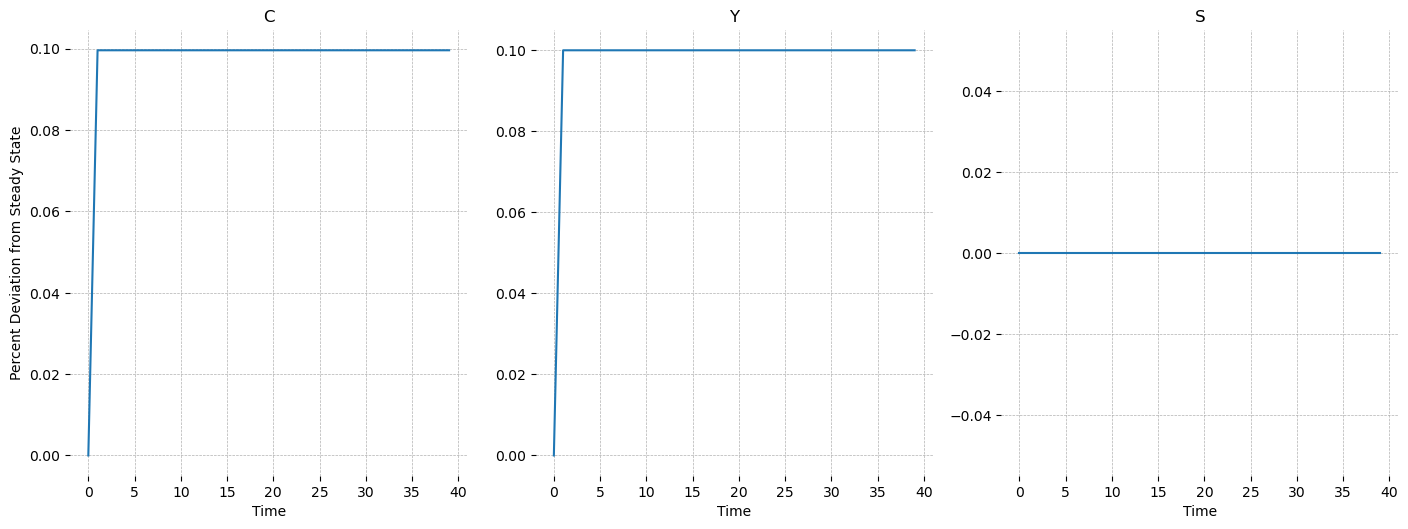

In [9]:
fig = gp.plot_irf(irf.round(4), vars_to_plot=['C', 'Y', 'S'], shocks_to_plot=['income_shock'])
axes = fig.axes
axes[0].set_ylabel('Percent Deviation from Steady State')
plt.show()

Since this shock is permanent, the household doesn't adjust it's savings plan! Instead, it jumps up to a higher level of consumption. In this way, the marginal propensity to consume (MPC) is 1. 

What if we look a different values of $rho$? As $\rho$ goes down, the income shocks become more and more transitory. Let's compare the $\rho \approx 1$ IRF to $\rho \approx 0$ 

To change a parameter, we can update it inside the `mod.free_param_dict`, then re-solve the model.

In [10]:
mod_1.free_param_dict['rho_Y'] = 0
mod_1.steady_state()
mod_1.solve_model(solver='gensys')
irf_rho_zero = mod_1.impulse_response_function(simulation_length=40, shock_size=0.1)

Steady state found! Sum of squared residuals is 1.0156918170108799e-19
Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [11]:
mod_1.free_param_dict['rho_Y'] = 0.9
mod_1.steady_state()
mod_1.solve_model(solver='gensys')
irf_rho_90 = mod_1.impulse_response_function(simulation_length=40, shock_size=0.1)

Steady state found! Sum of squared residuals is 1.0156918170108799e-19
Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


We can see that when $\rho = 1$, the household doesn't adjust their savings plan at all. Instead, the level of consumption jumps up by the same size as the shock. This is because there is no need to smooth consumption in the face of a permanent shock -- the existing consumption plan works fine, just at a higher level.

On the other hand, when $\rho = 0$, consumption barely increases at all. Savings increase significantly, reflecting consumption smoothing. The household saves almost all of the temporary income increase and uses it to fund a new, *sustainable* level of consumption for the rest of time.

Somewhere inbetween, at $\rho = 0.9$, we see that the household also uses savings to increase consumption. Contrary to the other scenarios, though, the household progressively saves more and more, until it reaches the new steady-state level of savings. This is because the shock lingers, generating surpluses for the household over time. The household is able to take advantage of this lingering good fortune to slowly accumulate a larger savings position, which in turn can fund a higher level of lifetime consumption.

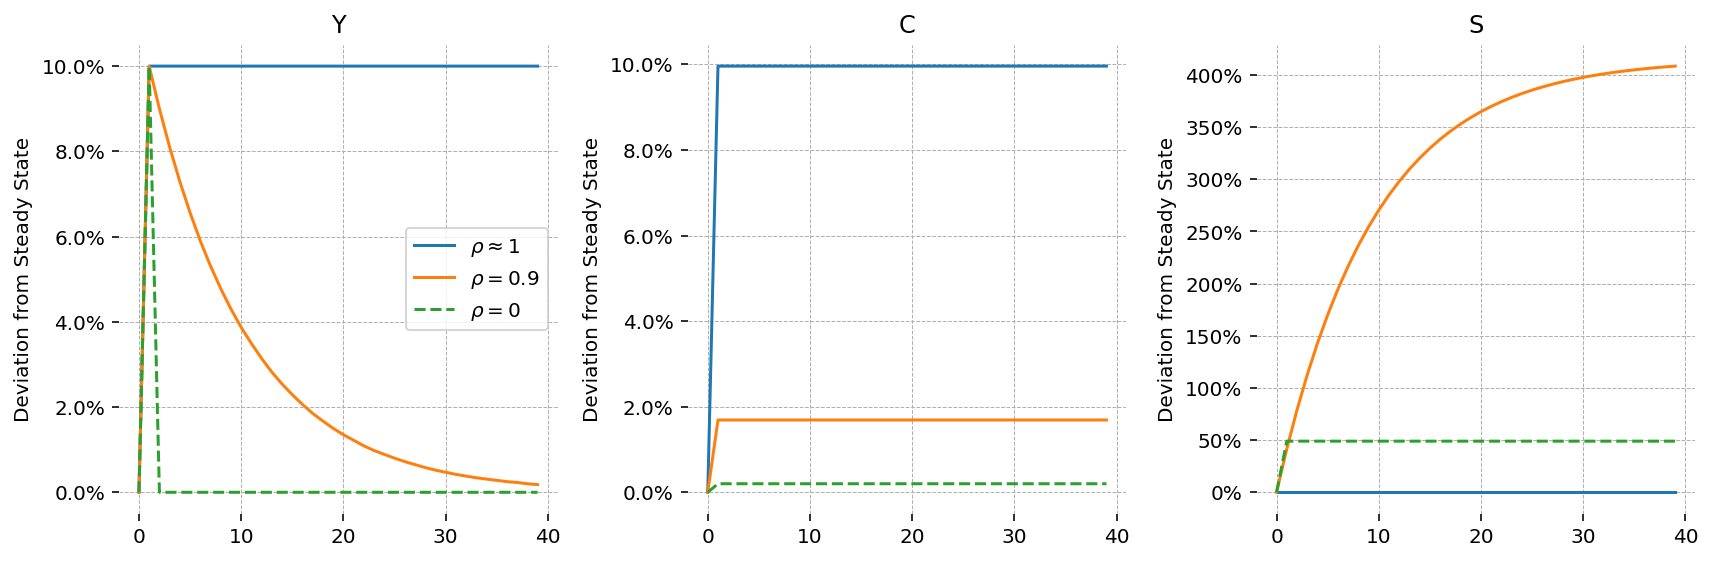

In [12]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(1, 3)
for var, axis in zip(['Y', 'C', 'S'], fig.axes):
    axis.plot(irf.T.droplevel(axis=0, level=1).round(4)[var], label=r'$\rho \approx 1$')
    axis.plot(irf_rho_90.T.droplevel(axis=0, level=1).round(4)[var], label=r'$\rho = 0.9$')
    axis.plot(irf_rho_zero.T.droplevel(axis=0, level=1).round(4)[var], ls='--', label=r'$\rho = 0$')
    
    axis.set_title(var)
    axis.yaxis.set_major_formatter(PercentFormatter(1))
    axis.set_ylabel('Deviation from Steady State')

fig.axes[0].legend()
fig.tight_layout()
plt.show()

In [13]:
0.01 ** 0.5

0.1

## Simulations

Another interesting thing we can do is simulate trajectories from the model. To do this, we don't just draw one shock to income -- we draw a sequence of shocks, $\varepsilon_{Y,t} \sim N(0, \sigma^2)$. In our case, we choose $\sigma^2 = 0.01$, so income varies by about +/- 2%. 

These trajectories come from the model with $\rho = 0.9$. Here are some things to notice:

1. The consumption trajectories change by much less than income and savings.  This is consumption smoothing -- the variance of consumption is much lower than the variance of income.

2. Savings change very slowly, but have very high variance. Whereas income increases to 100% of steady state, savings increase to 6,000%!

3. Income is **mean reverting**. This is a feature of AR(1) models, with $|\rho| < 1$. Although there are periods were income is above or below 0, it always comes back to zero eventually.

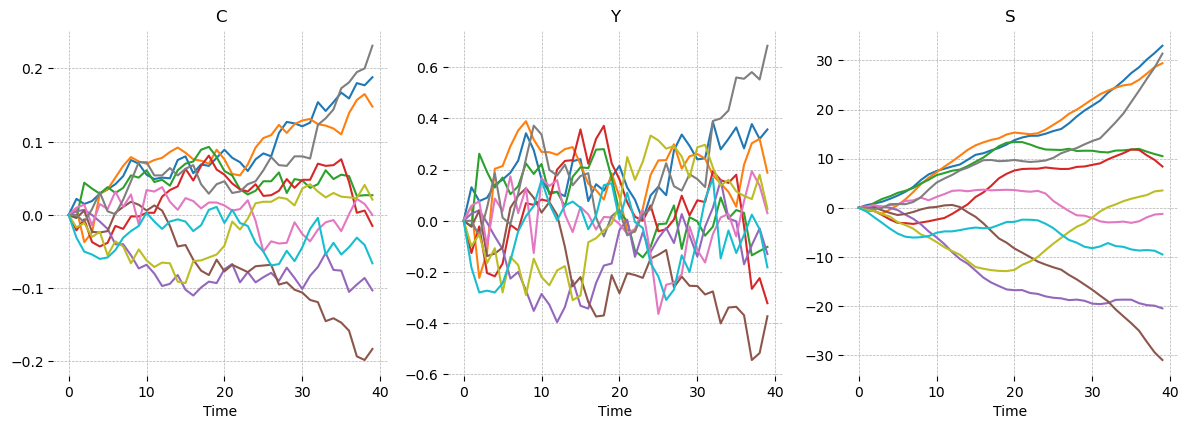

In [14]:
sim_1 = mod_1.simulate(simulation_length=40, shock_cov_matrix=np.eye(1) * 0.01, n_simulations=10)
sim_1 = sim_1.round(3)
gp.plot_simulation(sim_1, vars_to_plot=['C', 'Y', 'S']);

When $\rho \approx 1$, savings do no respond to shocks, and income follows a **gaussian random walk**. It no longer shows the mean-reverting tendency -- income now appears to be wandering anywhere it wants to. Hence the same, random walk.

Note also that consumption and income are now exactly the same -- this is because there is no savings, and the MPC of the household is 1.

Steady state found! Sum of squared residuals is 1.0156918170108799e-19
Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


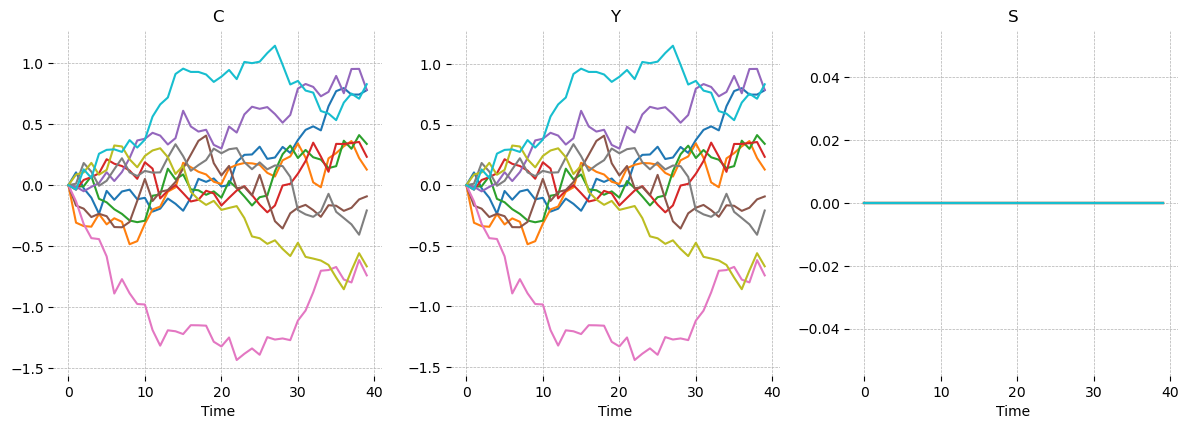

In [15]:
mod_1.free_param_dict['rho_Y'] = 1 - 1e-12
mod_1.steady_state()
mod_1.solve_model(solver='gensys')
sim_rho_1 = mod_1.simulate(simulation_length=40, shock_cov_matrix=np.eye(1) * 0.01, n_simulations=10)

gp.plot_simulation(sim_rho_1.round(3), vars_to_plot=['C', 'Y', 'S']);